# Lecture 7

## Generative Adversarial Nets

In preperation for this lecture we read the paper:  
[_Generative Adversarial Nets, Goodfellow et al. 2014_](http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf).  
Here we want to implement their method to train a Generator Network to generate samples of a specific data distribution.  
We will use PyTorch, for more information and tutorials on PyTorch checkout:  
http://pytorch.org/docs/  
http://pytorch.org/tutorials/

In [1]:
#lazy-import all the numpy and matplotlib stuff you need
%pylab inline

#some more imports
import os
cwd = os.getcwd()
from os.path import join as pj
from PIL import Image

#torch imports
import torch
from torch import optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

#torchvision imports
import torchvision.models as models
from torchvision import transforms

#IPython imports
from IPython import display


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:276: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
#define generator
class G(nn.Module):
    def __init__(self, nlatent=10, nfeat=100, nlayer=2, non_lin='relu', batch_norm=True):
        super(G, self).__init__()
        self.layers = nn.ModuleList()
        self.layers
        for l in range(nlayer):
            if l == 0:
                self.layers.append(nn.Linear(nlatent,nfeat))
            elif l == (nlayer-1):
                self.layers.append(nn.Linear(nfeat,784))
            else:
                self.layers.append(nn.Linear(nfeat,nfeat))
            if l < (nlayer-1): #add non-linearity and BN after all but last layer
                if batch_norm:
                    self.layers.append(nn.BatchNorm1d(nfeat, affine=True))
                if non_lin == 'relu':
                    self.layers.append(nn.ReLU(True))
                elif non_lin == 'elu':
                    self.layers.append(nn.ELU(True))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x                    

#define discriminator
class D(nn.Module):
    def __init__(self, nfeat=100, nlayer=2, non_lin='relu', batch_norm=True):
        super(D, self).__init__()
        self.layers = nn.ModuleList()
        self.layers
        for l in range(nlayer):
            if l == 0:
                self.layers.append(nn.Linear(784,nfeat))
            elif l == (nlayer-1):
                self.layers.append(nn.Linear(nfeat,1))
            else:
                self.layers.append(nn.Linear(nfeat,nfeat))
            if l < (nlayer-1): #add non-linearity and BN after all but last layer
                if batch_norm:
                    self.layers.append(nn.BatchNorm1d(nfeat, affine=True))
                if non_lin == 'relu':
                    self.layers.append(nn.ReLU(True))
                elif non_lin == 'elu':
                    self.layers.append(nn.ELU(True))

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x    

In [3]:
nepoch = 10
diter = 1 #iterations of discriminator per iteration of generator
show_iter = 100
batch_size = 32
lsgan = True
if lsgan:
    crit = nn.MSELoss()
else:
    crit = nn.BCEWithLogitsLoss()
nlatent = 10
nfeat = 1000
nlayer=3
nl = 'relu'
g = G(nlatent=nlatent, nfeat=nfeat, nlayer=nlayer, non_lin=nl)
d = D(nfeat=nfeat, nlayer=nlayer, non_lin=nl)
lr = 5e-4
opt_g = optim.Adam(g.parameters(), lr=lr)
opt_d = optim.Adam(d.parameters(), lr=lr)

In [4]:
import torchvision
import torchvision.transforms as transforms

#load dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)


Epoch: 10, Iteration: 1800, loss_g: 0.985583, loss_d_real: 0.105127, loss_d_fake: 0.041031


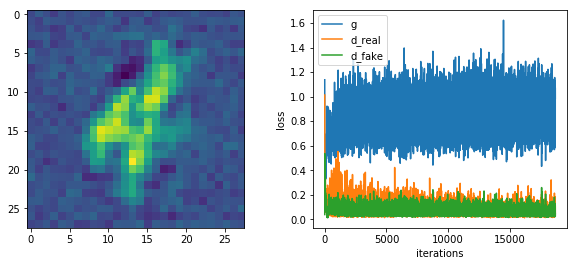

In [5]:
losses_d_real = []
losses_d_fake = []
losses_g = []
true_labels = Variable(torch.ones(batch_size, 1))
fake_labels = Variable(torch.zeros(batch_size, 1))
for n in range(nepoch):
    for i, data in enumerate(trainloader):
        #load real sample
        x, _ = data
        x = Variable(x)
        
        #generate sample
        z = torch.randn(batch_size, nlatent)
        z = Variable(z)
        xfake = g(z)
        
        #train discriminator
        opt_d.zero_grad()
        loss_d_real = crit(d(x), true_labels)
        loss_d_fake = crit(d(xfake.detach()), fake_labels)
        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        opt_d.step()
        losses_d_real.append(loss_d_real.data.mean())
        losses_d_fake.append(loss_d_fake.data.mean())
        
        #train generator
        if i%diter == 0:
            opt_g.zero_grad()
            loss_g = crit(d(xfake), true_labels)
            loss_g.backward()
            opt_g.step()
            losses_g.append(loss_g.data.mean())

        #show progress
        if i%show_iter == (show_iter-1):
            print('Epoch: %d, Iteration: %d, loss_g: %f, loss_d_real: %f, loss_d_fake: %f'%(n+1, i+1, loss_g.data[0],loss_d_real.data[0],loss_d_fake.data[0]))
            f,ax = subplots(1,2)
            ax[0].imshow(xfake[0].data.squeeze().numpy())
            ax[1].plot(losses_g)
            ax[1].plot(losses_d_real)
            ax[1].plot(losses_d_fake)
            ax[1].legend(['g','d_real','d_fake'])
            ax[1].set_xlabel('iterations')
            ax[1].set_ylabel('loss')
            f.set_size_inches([10,4])
            display.display(f)
            display.clear_output(wait=True)
            close(f)

In [6]:
def show(img):
    npimg = img.numpy()
    imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

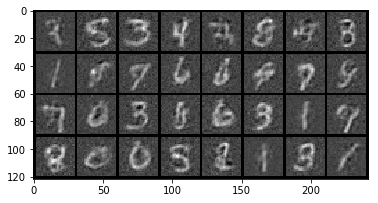

In [7]:
#show results
z = torch.randn(batch_size, nlatent)
z = Variable(z)
xfake = g(z)
show(torchvision.utils.make_grid(xfake.data, normalize=True))